In [2]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [39]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     29.251700     28.981150   
                          BTC     10532.400561  10596.176732  10451.465293   
                          ETH       221.191514    224.079639    221.015166   
                          XRP         0.319763      0.323658      0.319140   
2019-07-20 01:00:00+00:00 BNB        29.102050     30.051750     28.937300   
...                                        ...           ...           ...   
2022-09-02 08:00:00+00:00 ETH      1594.401429   1596.874286   1585.030000   
                          LINK        6.882598      6.912045      6.853060   
                          MATIC       0.881401      0.890773      0.880405   
                          SOL        31.624165     31.658390     31.415591   
                          XRP         0.331690      0.331690      0.330483   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        29.102300 2019-07-20 01:00:00+00:00   
                          BTC     10466.256172 2019-07-20 01:00:00+00:00   
                          ETH       221.450416 2019-07-20 01:00:00+00:00   
                          XRP         0.319678 2019-07-20 01:00:00+00:00   
2019-07-20 01:00:00+00:00 BNB        30.036500 2019-07-20 02:00:00+00:00   
...                                        ...                       ...   
2022-09-02 08:00:00+00:00 ETH      1590.434286 2022-09-02 09:00:00+00:00   
                          LINK        6.873536 2022-09-02 09:00:00+00:00   
                          MATIC       0.890107 2022-09-02 09:00:00+00:00   
                          SOL        31.562069 2022-09-02 09:00:00+00:00   
                          XRP         0.330670 2022-09-02 09:00:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB     0.063542  
                          BTC     0.034167  
                          ETH     0.034369  
                          XRP     0.043545  
2019-07-20 01:00:00+00:00 BNB     0.016383  
...                                    ...  
2022-09-02 08:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[245753 rows x 6 columns]

symbol,ADA,ATOM,BNB,BTC,DOT,ETH,LINK,MATIC,SOL,XRP
symbol,,,,,,,,,,
ADA,1.000000,0.626924,0.594237,0.633646,0.654896,0.700406,0.697513,0.629003,0.518430,0.551079
ATOM,0.626924,1.000000,0.536134,0.569383,0.687632,0.641561,0.671139,0.547249,0.509279,0.481103
BNB,0.594237,0.536134,1.000000,0.641363,0.612387,0.673026,0.641279,0.587338,0.513257,0.497849
BTC,0.633646,0.569383,0.641363,1.000000,0.662349,0.804224,0.680479,0.544420,0.489297,0.543676
DOT,0.654896,0.687632,0.612387,0.662349,1.000000,0.728487,0.741289,0.574377,0.561834,0.497877
ETH,0.700406,0.641561,0.673026,0.804224,0.728487,1.000000,0.798731,0.633893,0.596294,0.575734
LINK,0.697513,0.671139,0.641279,0.680479,0.741289,0.798731,1.000000,0.621218,0.579698,0.579772
MATIC,0.629003,0.547249,0.587338,0.544420,0.574377,0.633893,0.621218,1.000000,0.507328,0.464962
SOL,0.518430,0.509279,0.513257,0.489297,0.561834,0.596294,0.579698,0.507328,1.000000,0.400071


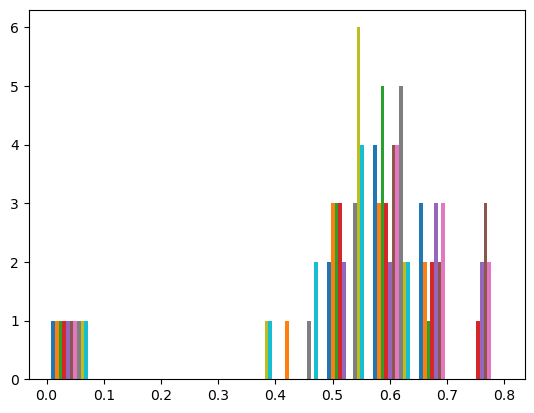

symbol,ADA,ATOM,BNB,BTC,DOT,ETH,LINK,MATIC,SOL,XRP
symbol,,,,,,,,,,
ADA,1.000000,-0.113690,-0.117682,-0.086227,-0.181418,-0.196260,-0.076464,-0.066698,-0.159960,0.043635
ATOM,-0.113690,1.000000,-0.212811,-0.257687,0.010085,-0.228957,-0.053095,-0.058280,-0.052726,-0.182574
BNB,-0.117682,-0.212811,1.000000,0.188482,-0.182621,-0.041455,-0.243400,-0.147069,-0.188372,0.030890
BTC,-0.086227,-0.257687,0.188482,1.000000,-0.219506,0.214528,-0.258685,-0.315403,-0.273015,0.140660
DOT,-0.181418,0.010085,-0.182621,-0.219506,1.000000,-0.140135,0.064795,-0.123977,-0.020658,-0.211285
ETH,-0.196260,-0.228957,-0.041455,0.214528,-0.140135,1.000000,-0.045026,-0.138646,-0.091599,-0.120006
LINK,-0.076464,-0.053095,-0.243400,-0.258685,0.064795,-0.045026,1.000000,-0.059073,-0.107751,-0.180354
MATIC,-0.066698,-0.058280,-0.147069,-0.315403,-0.123977,-0.138646,-0.059073,1.000000,-0.017674,-0.186922
SOL,-0.159960,-0.052726,-0.188372,-0.273015,-0.020658,-0.091599,-0.107751,-0.017674,1.000000,-0.284361


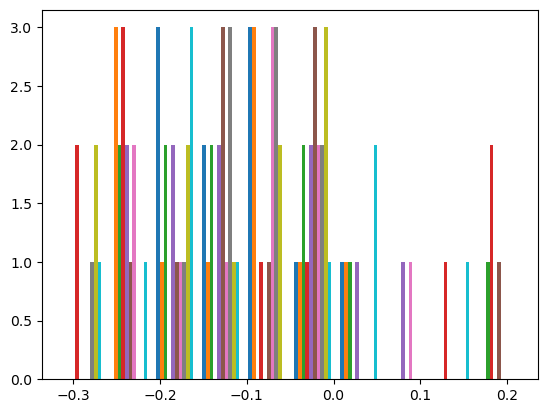

symbol,ADA,ATOM,BNB,BTC,DOT,ETH,LINK,MATIC,SOL,XRP
symbol,,,,,,,,,,
ADA,1.000000,-0.063083,-0.099681,0.002356,-0.097675,-0.036485,-0.053009,-0.102570,-0.214904,-0.019805
ATOM,-0.063083,1.000000,-0.187463,-0.107906,0.075796,-0.148237,-0.056833,-0.261262,-0.174258,-0.132716
BNB,-0.099681,-0.187463,1.000000,0.116557,-0.089142,0.018020,-0.087493,-0.094780,-0.119664,-0.058430
BTC,0.002356,-0.107906,0.116557,1.000000,0.047741,0.425679,0.029826,-0.215753,-0.180111,0.036199
DOT,-0.097675,0.075796,-0.089142,0.047741,1.000000,0.011548,0.052444,-0.319062,-0.140986,-0.182019
ETH,-0.036485,-0.148237,0.018020,0.425679,0.011548,1.000000,0.182315,-0.232928,-0.120165,-0.044203
LINK,-0.053009,-0.056833,-0.087493,0.029826,0.052444,0.182315,1.000000,-0.284138,-0.175088,-0.037291
MATIC,-0.102570,-0.261262,-0.094780,-0.215753,-0.319062,-0.232928,-0.284138,1.000000,-0.218789,-0.203813
SOL,-0.214904,-0.174258,-0.119664,-0.180111,-0.140986,-0.120165,-0.175088,-0.218789,1.000000,-0.203877


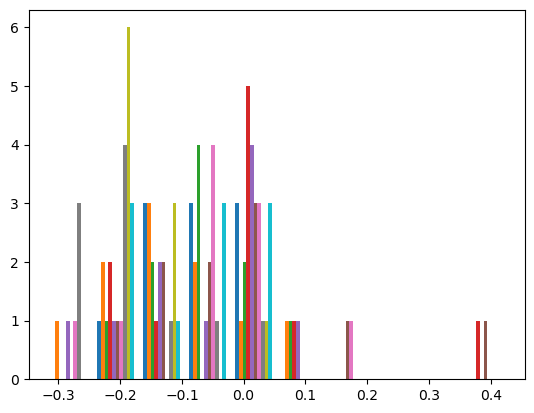

symbol,ADA,ATOM,BNB,BTC,DOT,ETH,LINK,MATIC,SOL,XRP
symbol,,,,,,,,,,
ADA,1.000000,0.614429,0.565057,0.618225,0.640515,0.680147,0.664654,0.631623,0.488704,0.545061
ATOM,0.614429,1.000000,0.518171,0.549574,0.680545,0.624875,0.647395,0.550147,0.501937,0.480262
BNB,0.565057,0.518171,1.000000,0.616353,0.589361,0.651774,0.603683,0.575865,0.494642,0.482688
BTC,0.618225,0.549574,0.616353,1.000000,0.633147,0.781655,0.633849,0.532637,0.447514,0.542039
DOT,0.640515,0.680545,0.589361,0.633147,1.000000,0.711674,0.721812,0.575031,0.551471,0.487847
ETH,0.680147,0.624875,0.651774,0.781655,0.711674,1.000000,0.762663,0.630926,0.567303,0.571040
LINK,0.664654,0.647395,0.603683,0.633849,0.721812,0.762663,1.000000,0.611173,0.548536,0.557236
MATIC,0.631623,0.550147,0.575865,0.532637,0.575031,0.630926,0.611173,1.000000,0.505734,0.476573
SOL,0.488704,0.501937,0.494642,0.447514,0.551471,0.567303,0.548536,0.505734,1.000000,0.379829


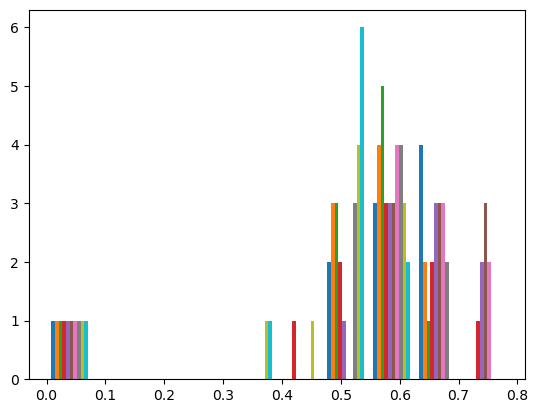

In [109]:
from sklearn.decomposition import PCA

df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5

df['ln_cl'] = np.log(df['cl'])
df['ln_cl_diff'] = (df['ln_cl'] - df.groupby('symbol')['ln_cl'].shift(1)).fillna(0)
df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
df['ret_mean'] = df.groupby('timestamp')['ret'].transform('mean')
# df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.expanding().corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0)
df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0)
# df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: talib.BETA(x, df.loc[x.index, 'ln_cl_diff_mean'], 24 * 30)).fillna(0)
df['ret_beta'] = df['ret'] - df['ret_mean'] * df['beta']

df = df.dropna()


df_x = df.reset_index().pivot(
    index='timestamp',
    columns='symbol',
    values='ret'
)
df_x = df_x.dropna()
display(df_x.corr())
plt.hist(df_x.corr().values - np.eye(df_x.shape[1]), bins=10)
plt.show()

df_x = df.reset_index().pivot(
    index='timestamp',
    columns='symbol',
    values='ret_rank'
)
df_x = df_x.dropna()
display(df_x.corr())
plt.hist(df_x.corr().values - np.eye(df_x.shape[1]), bins=10)
plt.show()

df_x = df.reset_index().pivot(
    index='timestamp',
    columns='symbol',
    values='ret'
)
df_x = df_x.dropna()
pca = PCA(n_components=1)
pca.fit(df_x)
df_x.iloc[:, :] -= pca.inverse_transform(pca.transform(df_x))
display(df_x.corr())
plt.hist(df_x.corr().values - np.eye(df_x.shape[1]), bins=10)
plt.show()

df_x = df.reset_index().pivot(
    index='timestamp',
    columns='symbol',
    values='ret_beta'
)
df_x = df_x.dropna()
display(df_x.corr())
plt.hist(df_x.corr().values - np.eye(df_x.shape[1]), bins=10)
plt.show()

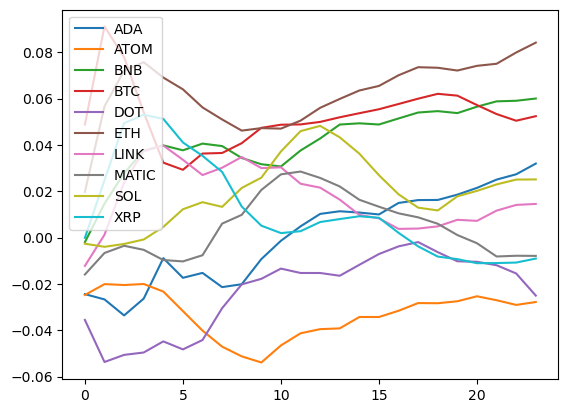

In [110]:
import talib
from scipy.stats import spearmanr, pearsonr

df_all = pd.read_pickle('/tmp/df_price_type_none.pkl')

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

def adx(t, high, low, close, volume):
    return talib.ADX(high, low, close, timeperiod=t)

def adxr(t, high, low, close, volume):
    return talib.ADXR(high, low, close, timeperiod=t)

def rsi(t, high, low, close, volume):
    return signed_rsi_sma(close, timeperiod=t)

def aroon_down(t, high, low, close, volume):
    return talib.AROON(high, low, timeperiod=t)[0]
def aroon_up(t, high, low, close, volume):
    return talib.AROON(high, low, timeperiod=t)[1]

def aroonosc(t, high, low, close, volume):
    return talib.AROONOSC(high, low, timeperiod=t)

def cci(t, high, low, close, volume):
    return talib.CCI(high, low, close, timeperiod=t)

def cmo(t, high, low, close, volume):
    return talib.CMO(close, timeperiod=t)

def dx(t, high, low, close, volume):
    return talib.DX(high, low, close, timeperiod=t)

def mfi(t, high, low, close, volume):
    return talib.MFI(high, low, close, volume, timeperiod=t)

def trix(t, high, low, close, volume):
    return talib.TRIX(close, timeperiod=t)

def calc_ret_beta(df):
    df['ln_cl'] = np.log(df['cl'])
    df['ln_cl_diff'] = (df['ln_cl'] - df.groupby('symbol')['ln_cl'].shift(1)).fillna(0)
    df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ret_mean'] = df.groupby('timestamp')['ret'].transform('mean')
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.expanding().corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0)
    df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0)
    df['ret_beta'] = df['ret'] - df['ret_mean'] * df['beta']

calc_ret_beta(df_all)
df_all['ret_rank'] = unbiased_rank(df_all.groupby('timestamp')['ret']) - 0.5

df_x = df_all.reset_index().pivot(
    index='timestamp',
    columns='symbol',
    values='ret'
)
df_x = df_x.fillna(0)
pca = PCA(n_components=1)
pca.fit(df_x)
df_x.iloc[:, :] -= pca.inverse_transform(pca.transform(df_x))
df2 = df_x.stack()
df_all['ret_pca'] = df2.loc[df_all.index]

def calc_corrs(func):
    corrs = {}
    for t in range(2, 24 * 7, 7):
        df_all['feature'] = df_all.groupby('symbol')['cl'].transform(lambda x: func(t, df_all.loc[x.index, 'hi'], df_all.loc[x.index, 'lo'], x, df_all.loc[x.index, 'volume']))
        df_all['feature_rank'] = unbiased_rank(df_all.groupby('timestamp')['feature']) - 0.5
        
        df_all['feature_mean'] = df_all.groupby('timestamp')['feature'].transform('mean')
        df_all['feature_beta'] = df_all['feature'] - df_all['feature_mean'] * df_all['beta']
        
        df_x = df_all.reset_index().pivot(
            index='timestamp',
            columns='symbol',
            values='feature'
        )
        df_x = df_x.fillna(0)
        df_x.iloc[:, :] -= pca.inverse_transform(pca.transform(df_x))
        df2 = df_x.stack()
        df_all['feature_pca'] = df2.loc[df_all.index]
        
        df2 = df_all.dropna()
        
        for symbol, df in df2.groupby('symbol'):
            if symbol not in corrs:
                corrs[symbol] = []
            # corrs[symbol].append(pearsonr(df['feature'], df['ret_rank'])[0])
            # corrs[symbol].append(pearsonr(df['feature_rank'], df['ret_rank'])[0])
            # corrs[symbol].append(pearsonr(df['feature_rank'], df['ret'])[0])
            # corrs[symbol].append(pearsonr(df['feature_rank'], df['ret_rank'])[0])
            # corrs[symbol].append(spearmanr(df['feature_rank'], df['ret_rank'])[0])
            # corrs[symbol].append(spearmanr(df['feature_rank'], df['ret_beta'])[0])
            # corrs[symbol].append(pearsonr(df['feature_beta'], df['ret_beta'])[0])
            # corrs[symbol].append(spearmanr(df['feature_beta'], df['ret_beta'])[0])
            # corrs[symbol].append(spearmanr(df['feature_rank'], df['ret'])[0])
            # corrs[symbol].append(pearsonr(df['feature_rank'], df['ret_pca'])[0])
            # corrs[symbol].append(pearsonr(df['feature_pca'], df['ret_pca'])[0])
            # corrs[symbol].append(spearmanr(df['feature_pca'], df['ret_pca'])[0])
            # corrs[symbol].append(spearmanr(df['feature_pca'], df['ret_rank'])[0])
            corrs[symbol].append(spearmanr(df['feature_beta'], df['ret_rank'])[0])
        
    return corrs

corrs = calc_corrs(rsi)
# corrs = calc_corrs(adx)
# corrs = calc_corrs(adxr)
# corrs = calc_corrs(cmo)
# corrs = calc_corrs(mfi)

for symbol in corrs:
    plt.plot(corrs[symbol], label=symbol)
    
plt.legend()
plt.show()

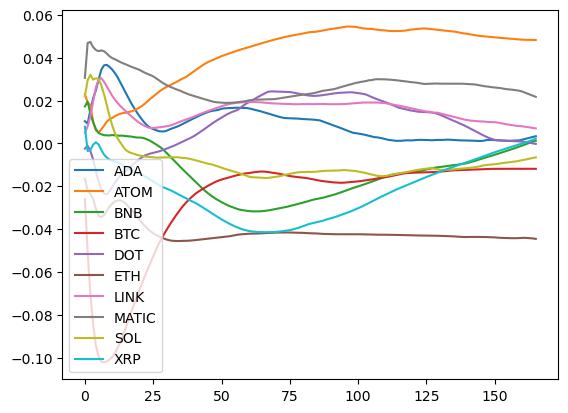

In [40]:
import talib
from scipy.stats import spearmanr

df_all = pd.read_pickle('/tmp/df_price_type_none.pkl')

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

df_all['ret_rank'] = unbiased_rank(df_all.groupby('timestamp')['ret']) - 0.5


for symbol, df in df_all.groupby('symbol'):
    df['ln_op'] = np.log1p(df['op'])
    df['ln_hi'] = np.log1p(df['hi'])
    df['ln_lo'] = np.log1p(df['lo'])
    df['ln_cl'] = np.log1p(df['cl'])
    df['ln_volume'] = np.log1p(df['volume'])

    high = df['hi']
    low = df['lo']
    close = df['hi']
    volume = df['volume']

    def calc_corrs(func):
        corrs = []
        for t in range(2, 24 * 7):
            df['adx'] = func(t)
            # corrs.append(df['adx'].corr(df['ret']))
            df2 = df.dropna()
            corrs.append(spearmanr(df2['adx'], df2['ret_rank'])[0])
        return np.array(corrs)

    def adx(t):
        return talib.ADX(high, low, close, timeperiod=t)

    def adxr(t):
        return talib.ADXR(high, low, close, timeperiod=t)
    
    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t)
    
    def aroon_down(t):
        return talib.AROON(high, low, timeperiod=t)[0]
    def aroon_up(t):
        return talib.AROON(high, low, timeperiod=t)[1]
    
    def aroonosc(t):
        return talib.AROONOSC(high, low, timeperiod=t)
    
    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t)
    
    def cmo(t):
        return talib.CMO(close, timeperiod=t)
    
    def dx(t):
        return talib.DX(high, low, close, timeperiod=t)
    
    def mfi(t):
        return talib.MFI(high, low, close, volume, timeperiod=t)
    
    def trix(t):
        return talib.TRIX(close, timeperiod=t)

    # plt.plot(calc_corrs(adx), label='adx')
    # plt.plot(calc_corrs(adxr), label='adxr')
    
    plt.plot(calc_corrs(adx), label=symbol)
    # plt.plot(calc_corrs(adxr), label=symbol)
    # plt.plot(calc_corrs(rsi), label=symbol)
    # plt.plot(calc_corrs(aroon_down), label=symbol)
    # plt.plot(calc_corrs(aroon_up), label=symbol)
    # plt.plot(calc_corrs(aroonosc), label=symbol)
    # plt.plot(calc_corrs(cci), label=symbol)
    # plt.plot(calc_corrs(cmo), label=symbol)
    # plt.plot(calc_corrs(dx), label=symbol)
    # plt.plot(calc_corrs(mfi), label=symbol)
    # plt.plot(calc_corrs(trix), label=symbol)
    
plt.legend()
plt.show()

In [106]:
class ExampleModelRank:
    def __init__(self):
        self._model = Ridge(fit_intercept=False, alpha=1e5)
        self.max_data_sec = 7 * 24 * 60 * 60 # for predict script

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        return self._model.fit(df[features], df['ret_rank'])
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        for i in [2, 4, 8, 24, 48, 72]:
            df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
        for i in [2, 4, 8, 24, 48, 72]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

        # symbol_count = df.reset_index()['symbol'].unique().size
            
        for col in get_feature_columns(df):
            df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
            # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
            # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))

        return df
    
def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos
    
def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

return without cost statistics
mean 0.0023011439919798675
std 0.01762893316877322
sharpe 0.13053223186845864
max drawdown 0.29271273531722536
return with cost statistics
mean 0.0014095371865222583
std 0.017644656411168406
sharpe 0.07988464913547844
max drawdown 0.2927927353172254


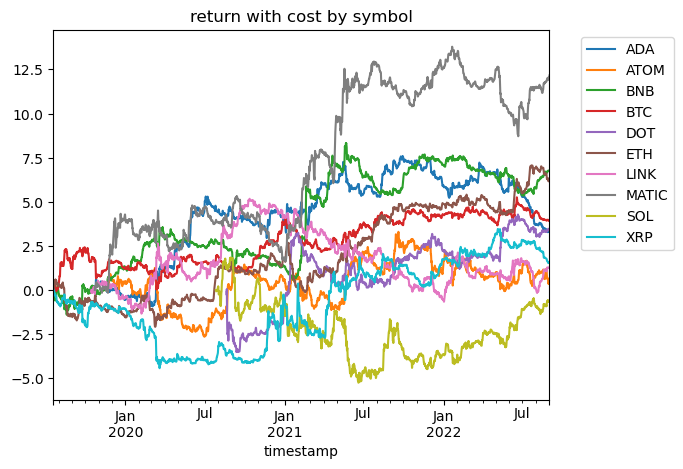

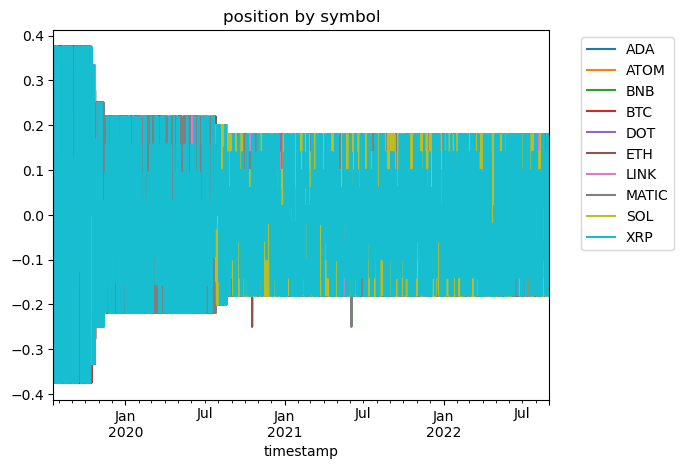

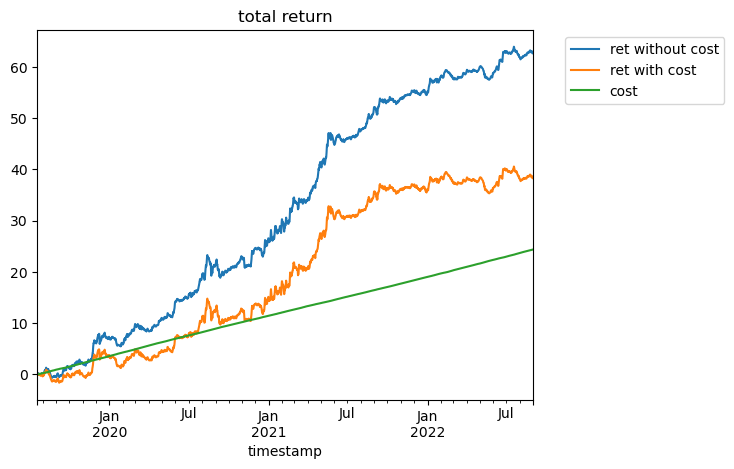

In [107]:
df = pd.read_pickle('/tmp/df.pkl')

model = ExampleModelRank()

# cv
calc_position_cv(model, df)
visualize_result(df.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/example_model_rank.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-08-26 08:00:00+00:00  ADA       0.00
                           ATOM      0.00
                           BNB       0.00
                           BTC       0.00
                           DOT       0.00
                                     ... 
2022-09-02 08:00:00+00:00  ETH      -0.06
                           LINK      0.18
                           MATIC     0.14
                           SOL      -0.14
                           XRP       0.02
Name: position, Length: 1690, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


position1  position2  position3
timestamp                 symbol                                 
2022-08-26 09:00:00+00:00 ADA         -0.10      -0.10       0.00
                          ATOM        -0.10      -0.10       0.00
                          BNB          0.10       0.10       0.00
                          BTC          0.10       0.10       0.00
                          DOT          0.10       0.10       0.00
...                                     ...        ...        ...
2022-09-02 07:00:00+00:00 ETH          0.06       0.06       0.06
                          LINK         0.14       0.14       0.14
                          MATIC        0.18       0.18       0.18
                          SOL         -0.14      -0.14      -0.14
                          XRP          0.02       0.02       0.02

[1670 rows x 3 columns]

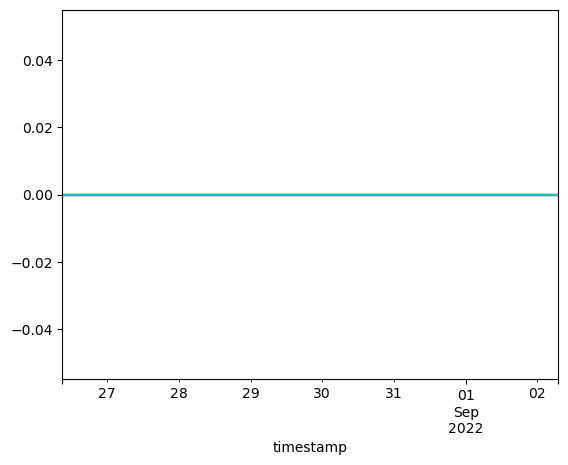

ADA (167, 4)
ATOM (167, 4)
BNB (167, 4)
BTC (167, 4)
DOT (167, 4)
ETH (167, 4)
LINK (167, 4)
MATIC (167, 4)
SOL (167, 4)
XRP (167, 4)


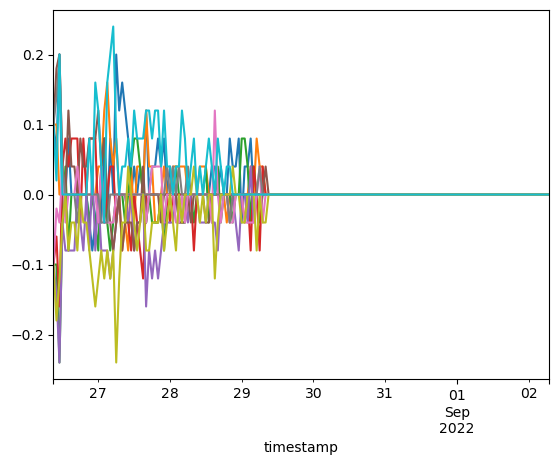

ADA (169, 3)
ATOM (169, 3)
BNB (169, 3)
BTC (169, 3)
DOT (169, 3)
ETH (169, 3)
LINK (169, 3)
MATIC (169, 3)
SOL (169, 3)
XRP (169, 3)


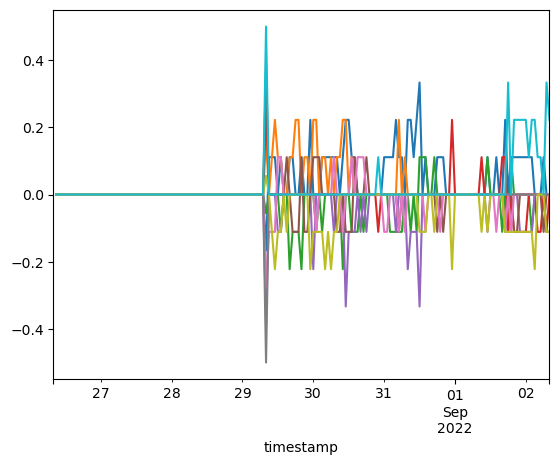

In [4]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/example_model_rank.xz')
df = pd.read_pickle('/tmp/df.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()